# Setup and Imports

In [1]:
import sys
if '../Toolkit' not in sys.path: sys.path.append('../Toolkit')

%load_ext autoreload
%autoreload 1

%aimport tools
%aimport models

import tools as t
import models as m

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
from IPython.display import clear_output

import numpy as np
import pandas as pd
pd.options.display.max_columns = None
pd.options.display.max_colwidth = 999
pd.options.display.max_rows = 113
import matplotlib.pyplot as plt
import seaborn as sns

RS = 35577 # global random state seed
raw_data_path = 'data-raw'
processed_data_path = 'data-processed'

In [2]:
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture

%aimport transformations

transformations loaded, version: 0.1


In [3]:
df_data = t.from_pkl(f'{processed_data_path}/data_clean.data.pkl')
df_data.shape
df_data.columns
df_data.head(3)

(4817, 13)

Index(['experiment_id', 'bearing_1_id', 'bearing_2_id', 'timestamp', 'a1_x',
       'a1_y', 'a1_z', 'a2_x', 'a2_y', 'a2_z', 'rpm', 'w', 'status'],
      dtype='object')

,experiment_id,bearing_1_id,bearing_2_id,timestamp,a1_x,a1_y,a1_z,a2_x,a2_y,a2_z,rpm,w,status
2888605,32,0,32,13.068333,-3.157405,1.285320,-3.567424,-0.846860,-3.650025,2.048633,1487.603306,1.051950,0
3424353,38,0,38,11.151000,0.786643,0.244341,-2.703137,-1.318881,3.558366,5.536239,1487.603306,1.142506,0
6165165,67,0,67,12.755000,-1.041087,0.244341,1.330203,3.212525,5.384492,-1.737910,1475.409836,0.549104,0


# Clustering

In [4]:
df_status_0 = df_data.loc[df_data['status'] == 0, 'experiment_id'].unique().tolist()[:3]
df_status_0
df_status_1 = df_data.loc[df_data['status'] == 1, 'experiment_id'].unique().tolist()[:3]
df_status_1

[32, 38, 67]

[107, 110, 109]

## KMeans

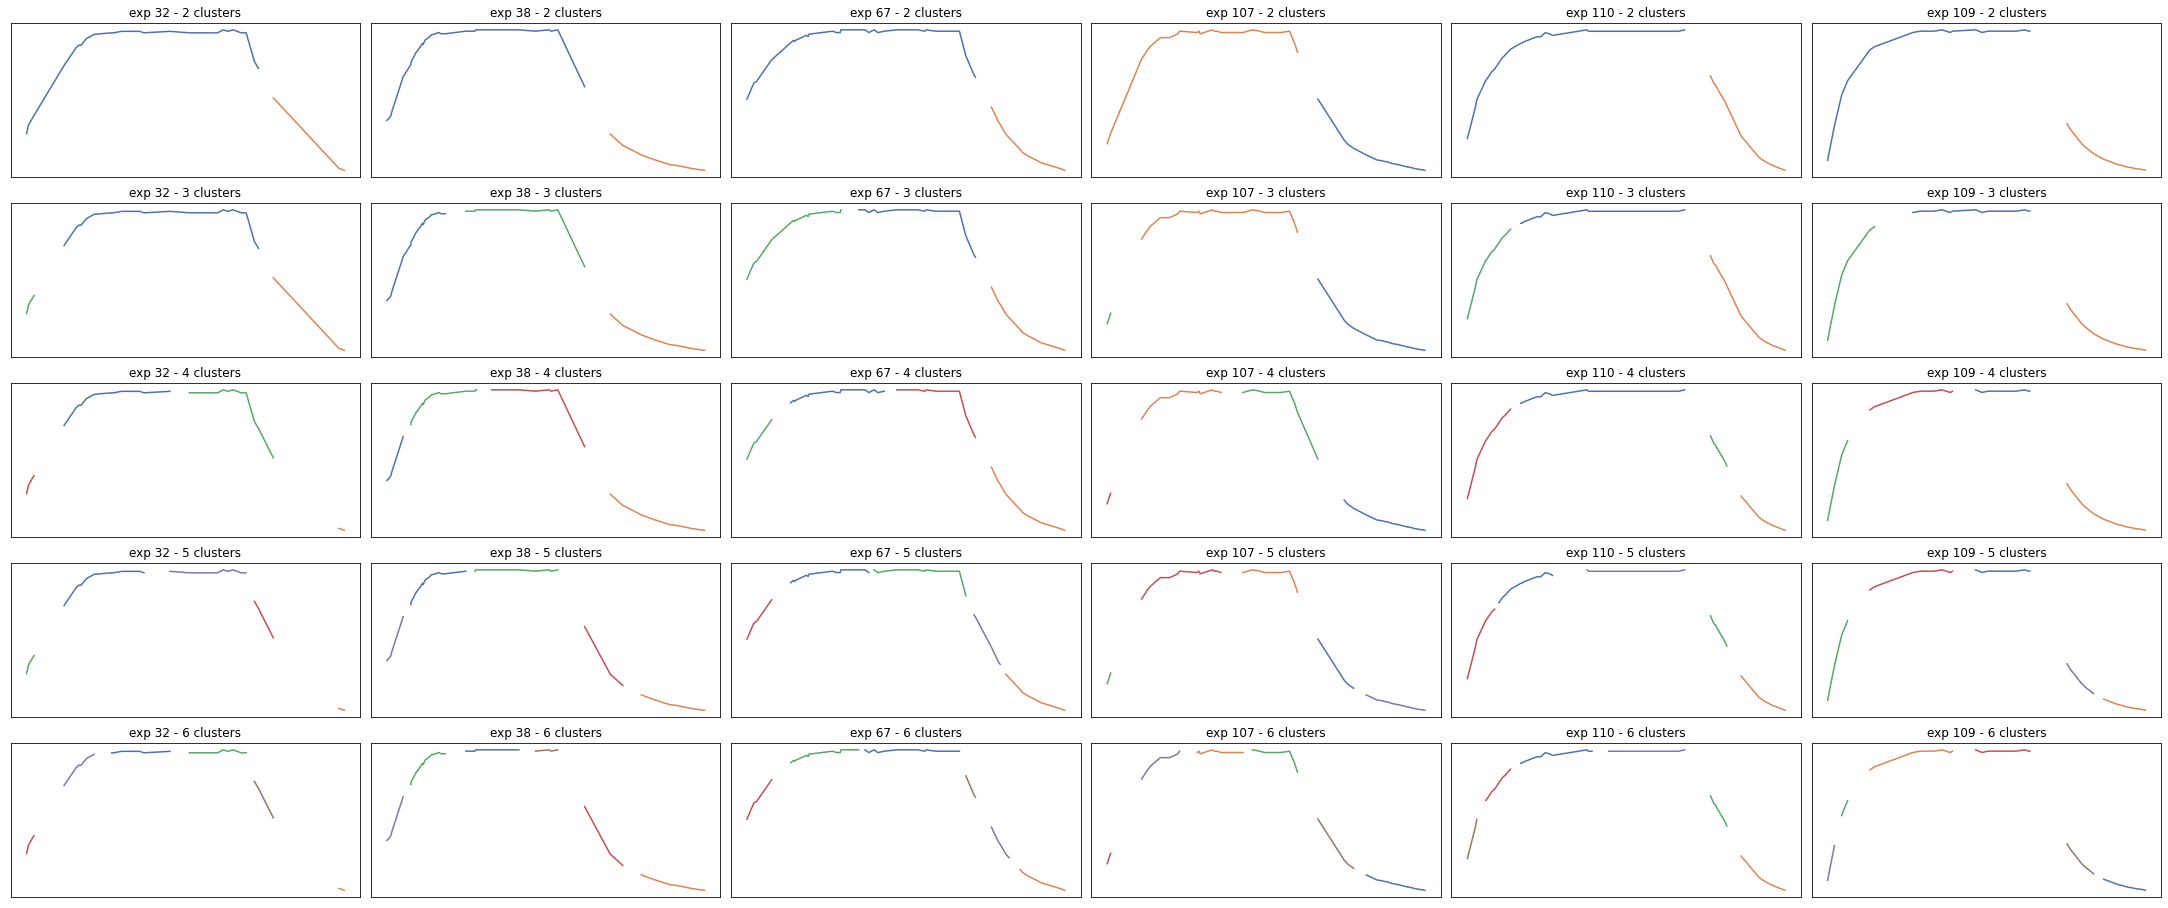

In [7]:
exp_ids = df_status_0 + df_status_1
n_clusters = list(range(2, 7))

axs = t.get_axes(len(n_clusters), len(exp_ids), 1/2 , 2)
    
for i_exp, exp_id in enumerate(exp_ids):

    df_cluster = df_data.loc[df_data['experiment_id'] == exp_id, ['timestamp','rpm']].copy()
    df_cluster[['timestamp','rpm']] = StandardScaler().fit_transform(df_cluster[['timestamp','rpm']])

    inertias = []
    cluster_n = []

    for n, ax  in zip( n_clusters, axs[:, i_exp]):
        model = KMeans(n_clusters=n, random_state=RS)
        clusters = model.fit_predict(df_cluster[['timestamp','rpm']])

        cluster_n.append(n)
        inertias.append(model.inertia_)
        _ = sns.lineplot(data=df_cluster, x='timestamp', y='rpm', hue=clusters, ax = ax, palette="deep", legend = False).set_title(f'exp {exp_id} - {n} clusters')
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
    # _ = f.get_ax(0.5, 2).plot(cluster_n, inertias)

## GaussianMixture

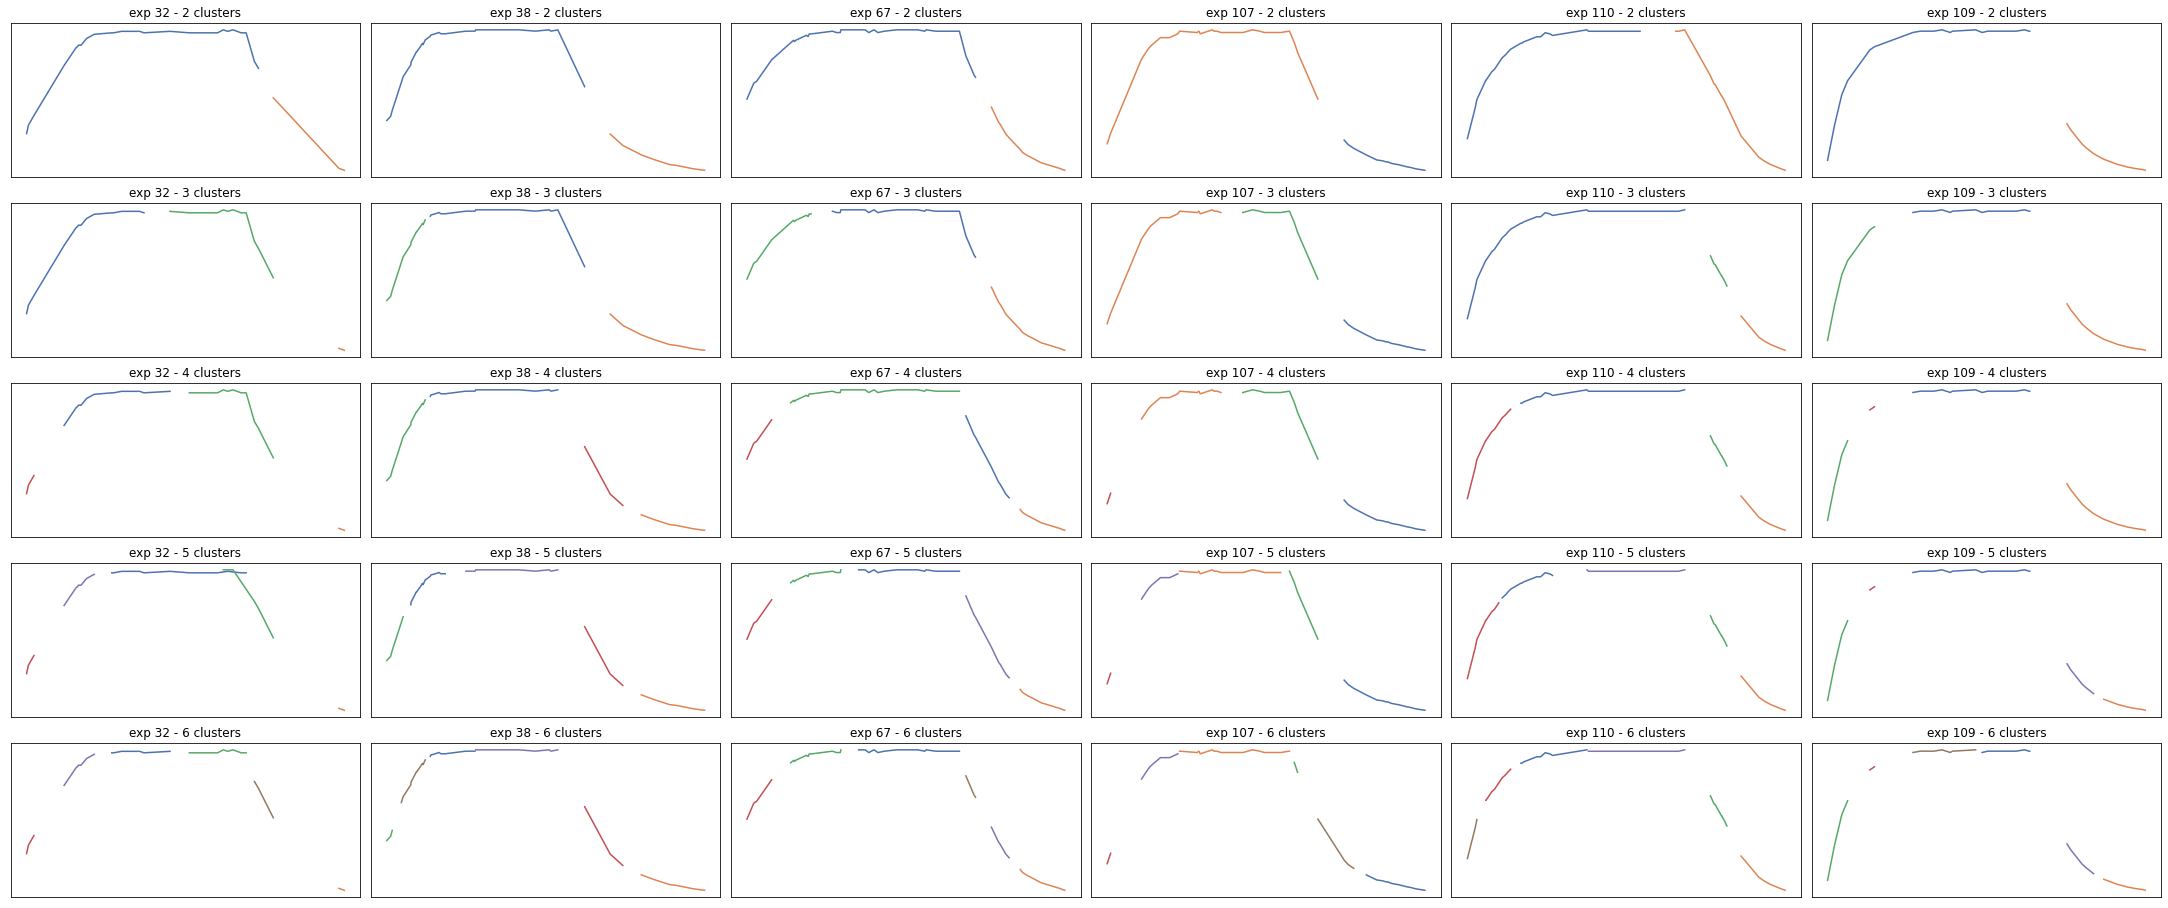

In [8]:
exp_ids = df_status_0 + df_status_1
n_clusters = list(range(2, 7))

axs = t.get_axes(len(n_clusters), len(exp_ids), 1/2 , 2)
    
for i_exp, exp_id in enumerate(exp_ids):

    df_cluster = df_data.loc[df_data['experiment_id'] == exp_id, ['timestamp','rpm']].copy()
    df_cluster[['timestamp','rpm']] = StandardScaler().fit_transform(df_cluster[['timestamp','rpm']])

    inertias = [] # BIC / AUC
    cluster_n = []

    for n, ax  in zip( n_clusters, axs[:, i_exp]):
        model = GaussianMixture(n_components=n, random_state=RS)
        clusters = model.fit_predict(df_cluster[['timestamp','rpm']])

        cluster_n.append(n)
        # inertias.append(model.inertia_)
        _ = sns.lineplot(data=df_cluster, x='timestamp', y='rpm', hue=clusters, ax = ax, palette="deep", legend = False).set_title(f'exp {exp_id} - {n} clusters')
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
    # _ = f.get_ax(0.5, 2).plot(cluster_n, inertias)

In [ ]:
# https://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html

# Cluster all RPM

In [11]:
def get_gm_lbls(df, pre_proc = StandardScaler):
    ss = pre_proc().fit_transform(df)
    gm_model = GaussianMixture(n_components=3, random_state=RS,)
    lbls = pd.DataFrame({'original_lbl': gm_model.fit_predict(ss)})

    old_to_new_lbl_map_df = pd.DataFrame({'x_mean':  gm_model.means_[:,0]}).reset_index().rename(columns={'index':'original_lbl'}).sort_values(by='x_mean').reset_index(drop=True).reset_index().rename(columns={'index':'new_lbl'}).drop('x_mean', axis=1)
    
    d_ret = pd.merge(lbls, old_to_new_lbl_map_df, on='original_lbl')
    return d_ret['new_lbl'].values

def add_clusters(df):
    df['rpm_clusters'] = None
    exp_ids = df['experiment_id'].unique()

    for exp_id in exp_ids:
        df.loc[df['experiment_id'] == exp_id, 'rpm_clusters'] = get_gm_lbls( df.loc[df['experiment_id'] == exp_id, ['timestamp','rpm']] )
        
def plot_rpm_clusters(df):
    exp_ids = df['experiment_id'].unique()
    axs = t.get_axes(int(np.ceil(len(exp_ids) / 4)), 4, 1/2)

    for ax in axs.flat:
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)

    for exp_id, ax in zip(exp_ids, axs.flat):
        df_plt = df.loc[df['experiment_id'] == exp_id]
        _ = sns.lineplot(data=df_plt, x='timestamp', y='rpm', hue='rpm_clusters', ax = ax, palette="deep", legend = False).set_title(f'exp {exp_id}')

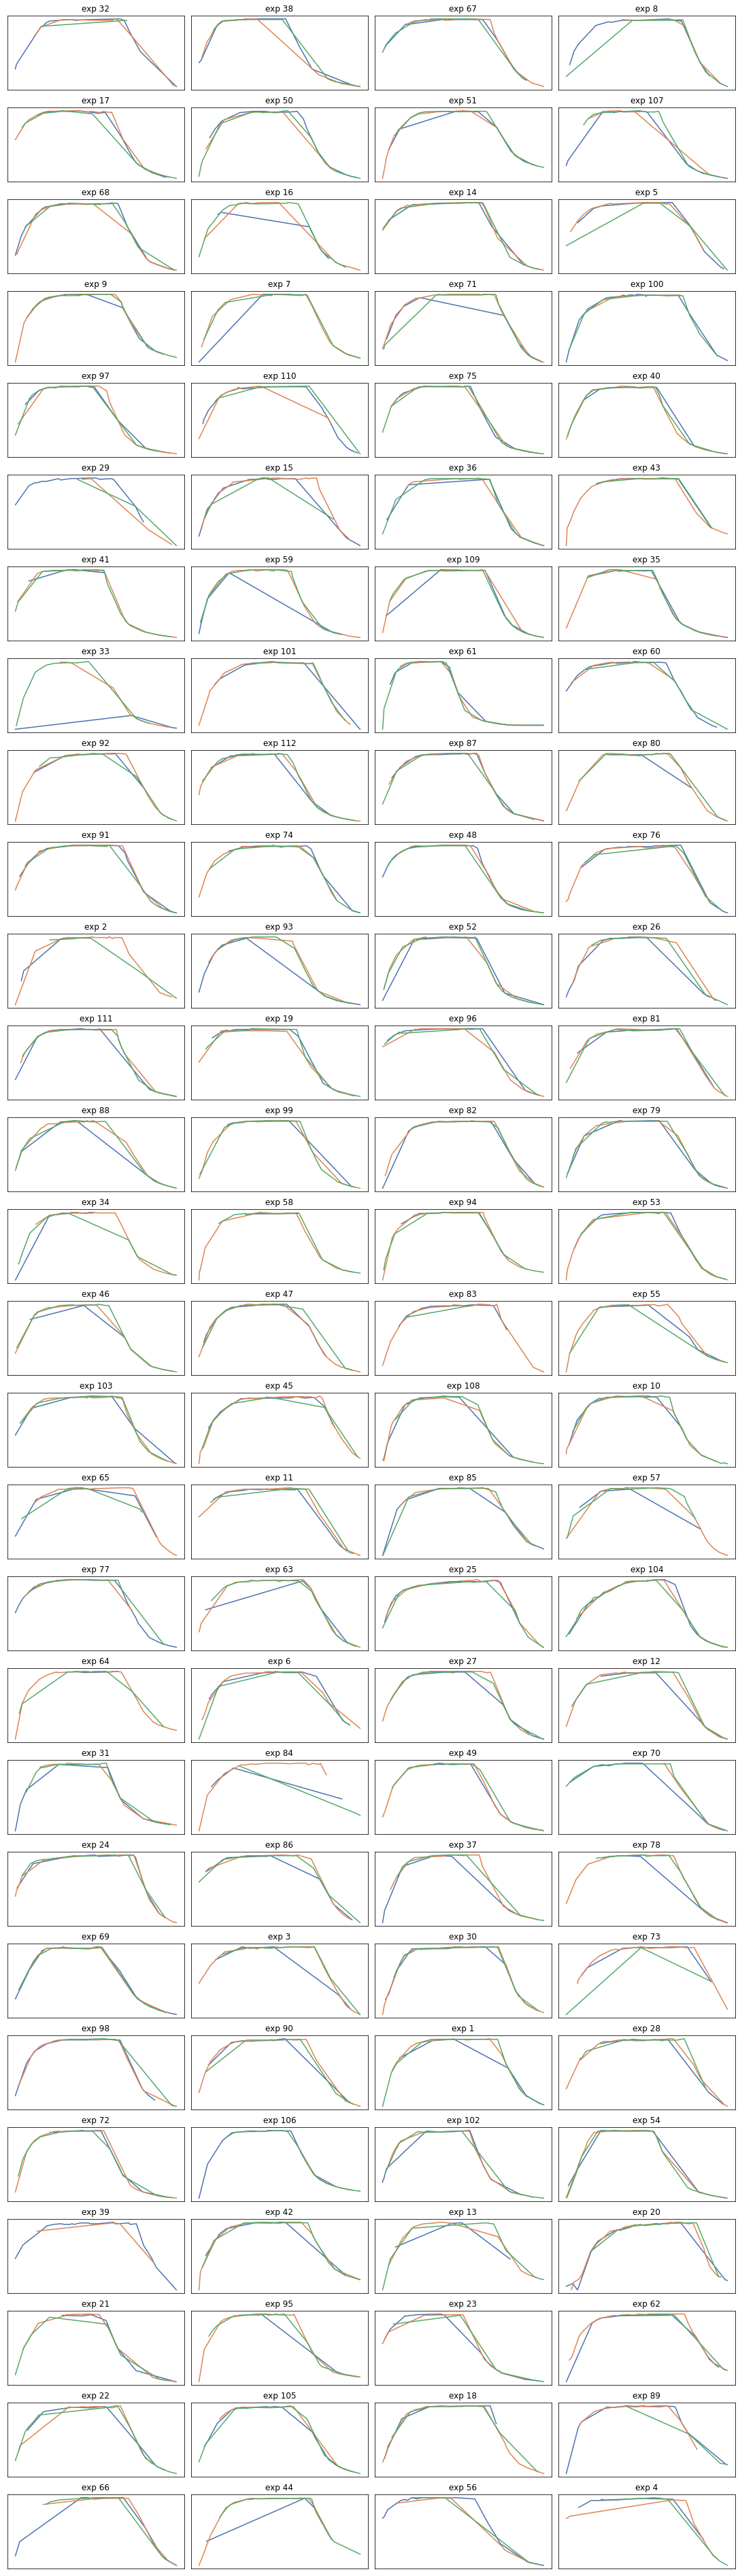

In [12]:
df_plt = df_data.copy()
add_clusters(df_plt)
plot_rpm_clusters(df_plt)

### Bad Ones

In [13]:
bad_exp_ids = [20, 21, 23, 29, 61, 104]

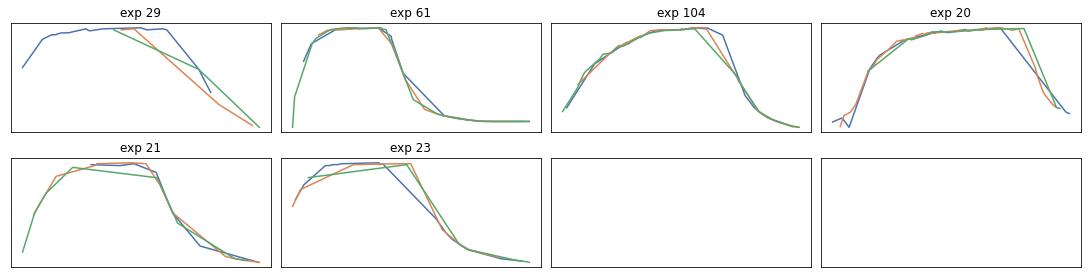

In [14]:
df_plt = df_plt.loc[df_plt['experiment_id'].isin(bad_exp_ids)].copy()
plot_rpm_clusters(df_plt)

### Remove rpm < 250 + Recluster

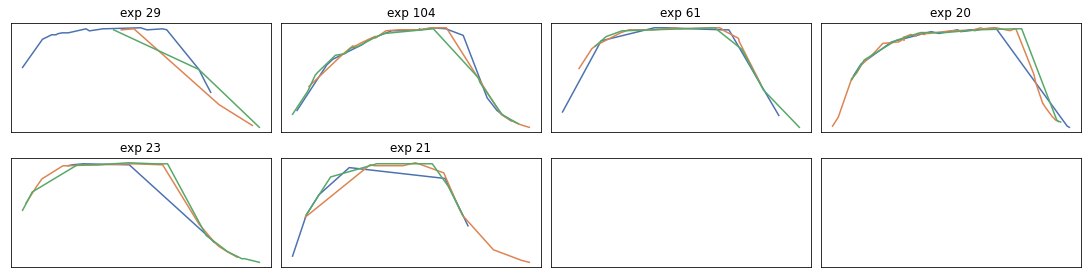

In [15]:
df_plt = df_data.loc[df_data['experiment_id'].isin(bad_exp_ids)].copy()

df_plt = df_plt.loc[df_plt['rpm'] > 250 ]

add_clusters(df_plt)
plot_rpm_clusters(df_plt)

In [16]:
# def get_gm_lbls(df, pre_proc = PowerTransformer):
#     ss = pre_proc().fit_transform(df)
#     gm_model = GaussianMixture(n_components=3, random_state=RS,)
#     lbls = pd.DataFrame({'original_lbl': gm_model.fit_predict(ss)})

#     old_to_new_lbl_map_df = pd.DataFrame({'x_mean':  gm_model.means_[:,0]}).reset_index().rename(columns={'index':'original_lbl'}).sort_values(by='x_mean').reset_index(drop=True).reset_index().rename(columns={'index':'new_lbl'}).drop('x_mean', axis=1)
    
#     d_ret = pd.merge(lbls, old_to_new_lbl_map_df, on='original_lbl')
#     return d_ret['new_lbl'].values

# def add_clusters(df):
#     df['rpm_clusters'] = None
#     exp_ids = df['experiment_id'].unique()

#     for exp_id in exp_ids:
#         df.loc[df['experiment_id'] == exp_id, 'rpm_clusters'] = get_gm_lbls( df.loc[df['experiment_id'] == exp_id, ['timestamp','rpm']] )
        
# def plot_rpm_clusters(df):
#     exp_ids = df['experiment_id'].unique()
#     axs = f.get_axes(int(np.ceil(len(exp_ids) / 4)), 4, 1 , 2)

#     for ax in axs.flat:
#         ax.axes.get_xaxis().set_visible(False)
#         ax.axes.get_yaxis().set_visible(False)

#     for exp_id, ax in zip(exp_ids, axs.flat):
#         df_plt = df.loc[df['experiment_id'] == exp_id]
#         _ = sns.lineplot(data=df_plt, x='timestamp', y='rpm', hue='rpm_clusters', ax = ax, palette="deep", legend = False).set_title(f'exp {exp_id}')

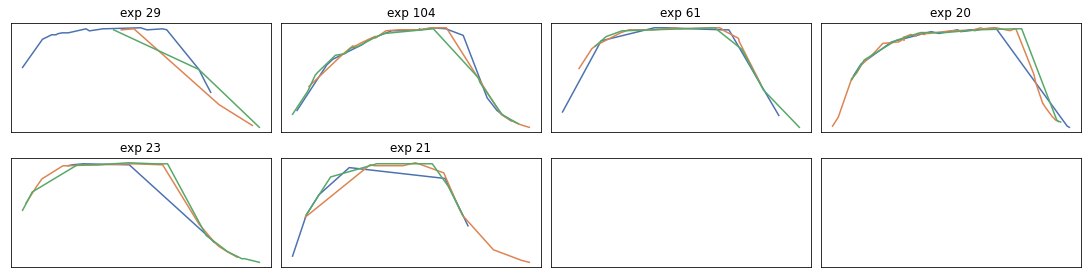

In [17]:
df_plt = df_data.loc[df_data['experiment_id'].isin(bad_exp_ids)].copy()

df_plt = df_plt.loc[df_plt['rpm'] > 250 ]

add_clusters(df_plt)
plot_rpm_clusters(df_plt)

### Start rpm at the same number + Recluster

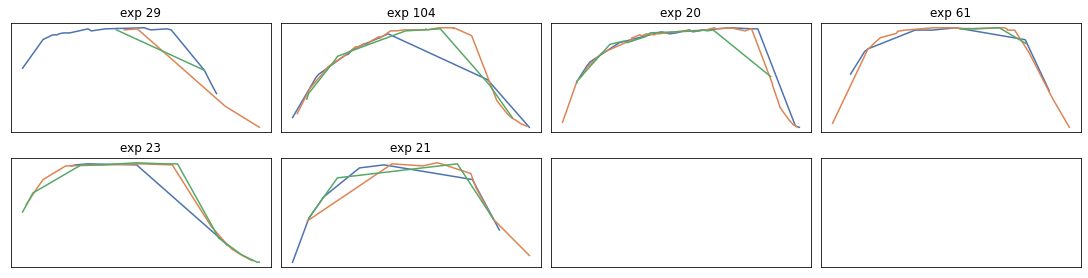

In [18]:
df_plt = df_data.loc[df_data['experiment_id'].isin(bad_exp_ids)].copy()

max_common_min_rpm = df_plt.groupby(['experiment_id'])['rpm'].min().sort_values(ascending=False).max()
df_plt = df_plt.loc[df_plt['rpm'] > max_common_min_rpm ]

add_clusters(df_plt)
plot_rpm_clusters(df_plt)

## Power Transformer